In [ ]:
!pip install tensorflow keras opencv-python numpy matplotlib pandas requests

In [ ]:
# Standard Library Imports
import os
import shutil
from io import BytesIO
from datetime import datetime
from typing import Tuple, List, Dict, Optional

# Third-Party Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
from PIL import Image
import seaborn as sns  # For enhanced visualizations

# TensorFlow/Keras Imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications, metrics
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model  # For model visualization

# Additional Useful Imports
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm  # For progress bars
import json  # For saving/loading configurations

In [ ]:
"""
Food-101 Dataset Download and Setup Script

Enhanced features:
1. Progress tracking during download
2. Checksum verification
3. Proper error handling
4. Storage management
5. Dataset validation
"""

import os
import tarfile
import requests
from tqdm import tqdm
import hashlib

def download_file(url: str, filename: str) -> bool:
    """Download file with progress bar and error handling"""
    try:
        print(f"🔽 Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status()

        # Get total size for progress bar
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1KB chunks

        with open(filename, 'wb') as f, tqdm(
            total=total_size,
            unit='B',
            unit_scale=True,
            desc=os.path.basename(filename)
        ) as pbar:
            for data in response.iter_content(block_size):
                f.write(data)
                pbar.update(len(data))

        print("✅ Download completed successfully!")
        return True

    except Exception as e:
        print(f"❌ Download failed: {e}")
        return False

def verify_checksum(filename: str, expected_hash: str) -> bool:
    """Verify file integrity using SHA-256 checksum"""
    print("🔍 Verifying file integrity...")
    sha256_hash = hashlib.sha256()

    try:
        with open(filename, 'rb') as f:
            # Read and update hash in chunks
            for byte_block in iter(lambda: f.read(4096), b""):
                sha256_hash.update(byte_block)

        file_hash = sha256_hash.hexdigest()
        if file_hash == expected_hash:
            print("✅ Checksum verified!")
            return True
        else:
            print(f"❌ Checksum mismatch!\nExpected: {expected_hash}\nGot: {file_hash}")
            return False

    except Exception as e:
        print(f"❌ Checksum verification failed: {e}")
        return False

def extract_tarfile(filename: str, delete_after: bool = True) -> bool:
    """Extract tar.gz file with progress tracking"""
    try:
        print(f"📂 Extracting {filename}...")
        with tarfile.open(filename, 'r:gz') as tar:
            members = tar.getmembers()
            for member in tqdm(members, desc="Extracting"):
                tar.extract(member)

        if delete_after:
            os.remove(filename)
            print("♻️ Removed archive file to save space")

        print("✅ Extraction completed!")
        return True

    except Exception as e:
        print(f"❌ Extraction failed: {e}")
        return False

def validate_dataset(directory: str) -> bool:
    """Basic validation of dataset structure"""
    required_dirs = ['images', 'meta']
    print("\n🔍 Validating dataset structure...")

    try:
        for dir_name in required_dirs:
            if not os.path.exists(os.path.join(directory, dir_name)):
                print(f"❌ Missing directory: {dir_name}")
                return False

        print("✅ Dataset structure looks good!")
        return True

    except Exception as e:
        print(f"❌ Validation error: {e}")
        return False

# Main execution
if __name__ == "__main__":
    # Configuration
    DATASET_URL = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
    ARCHIVE_NAME = "food-101.tar.gz"
    EXPECTED_SHA256 = "85eeb15f8a8c5a7e44a41e04a3e1f1e792d5b4a4a9e8d5a7e44a41e04a3e1f1e"  # Example checksum

    # Step 1: Download
    if not download_file(DATASET_URL, ARCHIVE_NAME):
        exit(1)

    # Step 2: Verify (optional but recommended)
    if not verify_checksum(ARCHIVE_NAME, EXPECTED_SHA256):
        print("⚠️ Continuing despite checksum mismatch...")
        # exit(1)  # Uncomment to enforce checksum verification

    # Step 3: Extract
    if not extract_tarfile(ARCHIVE_NAME):
        exit(1)

    # Step 4: Validate
    if not validate_dataset("food-101"):
        exit(1)

    print("\n🎉 Food-101 dataset is ready to use!")
    print(f"Total size: {sum(os.path.getsize(f) for f in os.listdir('.') if os.path.isfile(f)) / (1024**2):.2f} MB")

🔽 Downloading http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz...


food-101.tar.gz: 100%|██████████| 5.00G/5.00G [01:18<00:00, 63.3MB/s]


✅ Download completed successfully!
🔍 Verifying file integrity...
❌ Checksum mismatch!
Expected: 85eeb15f8a8c5a7e44a41e04a3e1f1e792d5b4a4a9e8d5a7e44a41e04a3e1f1e
Got: d97d15e438b7f4498f96086a4f7e2fa42a32f2712e87d3295441b2b6314053a4
⚠️ Continuing despite checksum mismatch...
📂 Extracting food-101.tar.gz...


Extracting: 100%|██████████| 101112/101112 [00:59<00:00, 1688.86it/s]


♻️ Removed archive file to save space
✅ Extraction completed!

🔍 Validating dataset structure...
✅ Dataset structure looks good!

🎉 Food-101 dataset is ready to use!
Total size: 0.00 MB


In [ ]:
"""
Enhanced Data Pipeline for Food-101 Classification

Features:
- Proper EfficientNet preprocessing
- Comprehensive augmentation
- Dataset validation
- Resource monitoring
"""

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import psutil  # For resource monitoring
import os

# Configuration
CONFIG = {
    'dataset_path': 'food-101/images',
    'target_size': (380, 380),  # EfficientNetB4 optimal size
    'batch_size': 32,
    'validation_split': 0.2,
    'random_seed': 42,
    'augmentation': {
        'rotation_range': 30,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'shear_range': 0.15,
        'zoom_range': 0.2,
        'horizontal_flip': True,
        'vertical_flip': False,
        'fill_mode': 'reflect'
    }
}

def check_dataset_health(dataset_path):
    """Validate dataset structure and accessibility"""
    required_items = ['apple_pie', 'pizza', 'sushi']  # Sample classes to check
    for item in required_items:
        class_path = os.path.join(dataset_path, item)
        if not os.path.exists(class_path):
            raise ValueError(f"Missing expected class directory: {class_path}")
        if len(os.listdir(class_path)) < 10:  # Minimum expected samples per class
            print(f"⚠️ Warning: Few samples in {item}")

def monitor_resources():
    """Log system resource utilization"""
    print(f"\n🖥️ System Resources:")
    print(f"CPU: {psutil.cpu_percent()}% | Memory: {psutil.virtual_memory().percent}%")

def create_data_generators():
    """Create optimized data generators with validation"""
    # Verify dataset first
    check_dataset_health(CONFIG['dataset_path'])
    monitor_resources()

    # Training generator with augmentation
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,  # EfficientNet specific
        validation_split=CONFIG['validation_split'],
        **CONFIG['augmentation']
    )

    # Validation generator (no augmentation)
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=CONFIG['validation_split']
    )

    print("\n🔧 Creating data generators...")

    # Training generator
    train_generator = train_datagen.flow_from_directory(
        CONFIG['dataset_path'],
        target_size=CONFIG['target_size'],
        batch_size=CONFIG['batch_size'],
        class_mode='categorical',
        subset='training',
        seed=CONFIG['random_seed'],
        shuffle=True
    )

    # Validation generator
    val_generator = val_datagen.flow_from_directory(
        CONFIG['dataset_path'],
        target_size=CONFIG['target_size'],
        batch_size=CONFIG['batch_size'],
        class_mode='categorical',
        subset='validation',
        seed=CONFIG['random_seed'],
        shuffle=False  # Important for consistent validation
    )

    # Verify batch shapes
    sample_batch, _ = next(train_generator)
    print(f"\n✅ Generators created successfully!")
    print(f"Input shape: {sample_batch.shape}")
    print(f"Classes: {train_generator.class_indices}")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")

    return train_generator, val_generator

# Create generators and make them accessible globally
train_gen, val_gen = create_data_generators()

# Example usage in model training:
# model.fit(
#     train_gen,
#     validation_data=val_gen,
#     steps_per_epoch=len(train_gen),
#     validation_steps=len(val_gen),
#     epochs=10
# )


🖥️ System Resources:
CPU: 10.0% | Memory: 14.3%

🔧 Creating data generators...
Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.

✅ Generators created successfully!
Input shape: (32, 380, 380, 3)
Classes: {'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, '

In [ ]:
"""
Enhanced EfficientNetB4 Base Model Configuration

Key improvements:
1. Optimal input size for EfficientNetB4
2. Proper preprocessing
3. Memory-efficient setup
4. Customizable unfreezing
"""

from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_enhanced_base_model(
    input_shape=(380, 380, 3),  # Optimal for EfficientNetB4
    weights='imagenet',
    include_top=False,
    pooling=None,
    freeze_until=100  # Freeze first 100 layers by default
):
    """
    Build enhanced EfficientNetB4 base model with configuration options

    Args:
        input_shape: Tuple - Optimal is (380, 380, 3) for EfficientNetB4
        weights: str - Pretrained weights ('imagenet' or path)
        include_top: bool - Whether to include classification head
        pooling: Optional[str] - Pooling mode ('avg', 'max', None)
        freeze_until: int - Freeze layers until this index

    Returns:
        tf.keras.Model - Configured base model
    """
    # Initialize base model with proper input shape
    base_model = EfficientNetB4(
        weights=weights,
        include_top=include_top,
        input_shape=input_shape,
        pooling=pooling
    )

    # Freeze layers according to strategy
    if freeze_until > 0:
        for layer in base_model.layers[:freeze_until]:
            layer.trainable = False
        print(f"✅ Frozen first {freeze_until} layers")

    # Add custom preprocessing layer
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # The model includes built-in preprocessing
    x = base_model(x)

    return Model(inputs, x, name='enhanced_EfficientNetB4')

# Example usage:
if __name__ == "__main__":
    # Initialize with optimal settings
    base_model = build_enhanced_base_model(
        input_shape=(380, 380, 3),
        freeze_until=100  # Freeze first 100 layers
    )

    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(101, activation='softmax')(x)  # For Food-101

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile with custom learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_k_categorical_accuracy']
    )

    print("\nModel summary:")
    model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ Frozen first 100 layers

Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1792)           │         7,168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       181,093 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,862,084 (68.14 MB)

 Trainable params: 17,646,533 (67.32 MB)

 Non-trainable params: 215,551 (842.00 KB)

In [ ]:
def freeze_model_layers(model, freeze=True, num_layers_to_freeze=None):
    """
    Enhanced model freezing with verification and flexible control

    Args:
        model: Keras model to freeze
        freeze: Boolean whether to freeze or unfreeze
        num_layers_to_freeze: Optional int to freeze specific number of layers
                             If None, freezes all trainable layers
    """
    if freeze:
        if num_layers_to_freeze is None:
            # Freeze entire model
            model.trainable = False
            print(f"❄️ Frozen all layers in {model.name}")
        else:
            # Freeze specific number of layers
            for i, layer in enumerate(model.layers[:num_layers_to_freeze]):
                layer.trainable = False
            print(f"❄️ Frozen first {num_layers_to_freeze} layers in {model.name}")
    else:
        # Unfreeze entire model
        model.trainable = True
        print(f"🔥 Unfroze all layers in {model.name}")

    # Verification
    trainable_count = sum([1 for layer in model.layers if layer.trainable])
    total_count = len(model.layers)
    print(f"Trainable layers: {trainable_count}/{total_count}")
    print(f"First trainable layer: {next((layer.name for layer in model.layers if layer.trainable), 'None')}")

    return model

# Usage examples:

# 1. Basic freezing (equivalent to base_model.trainable = False)
base_model = freeze_model_layers(base_model)

# 2. Freeze first 100 layers only
base_model = freeze_model_layers(base_model, num_layers_to_freeze=100)

# 3. Unfreeze model
base_model = freeze_model_layers(base_model, freeze=False)

❄️ Frozen all layers in enhanced_EfficientNetB4
Trainable layers: 0/2
First trainable layer: None
❄️ Frozen first 100 layers in enhanced_EfficientNetB4
Trainable layers: 0/2
First trainable layer: None
🔥 Unfroze all layers in enhanced_EfficientNetB4
Trainable layers: 2/2
First trainable layer: input_layer_1


In [ ]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model # Import Model

def build_model_head(base_model, num_classes, train_generator=None):
    """
    Build enhanced classification head with:
    - Batch normalization
    - Regularization
    - Adaptive activation
    - Proper initialization
    """
    x = base_model.output

    # Feature extraction
    x = GlobalAveragePooling2D()(x)

    # First dense layer with enhanced features
    x = Dense(
        1024,
        kernel_initializer='he_normal',
        kernel_regularizer=l2(0.01)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)  # Slightly reduced from 0.5

    # Second dense layer
    x = Dense(
        512,
        kernel_initializer='he_normal',
        kernel_regularizer=l2(0.01)
    )(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)

    # Output layer
    if train_generator:
        num_classes = len(train_generator.class_indices)
    predictions = Dense(
        num_classes,
        activation='softmax',
        kernel_initializer='glorot_uniform'
    )(x)

    return predictions

def compile_enhanced_model(model, initial_lr=0.001):
    """
    Enhanced model compilation with:
    - Custom optimizer configuration
    - Additional metrics
    - Learning rate scheduling
    """
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=initial_lr,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    return model

# Usage example:
if __name__ == "__main__":
    # Assuming base_model is already defined from a previous cell
    # You also need to run the cell that creates train_gen and val_gen
    # For demonstration, let's assume train_gen is available here.
    # In a real pipeline, you would pass train_gen from the data loading step.
    # For this example, we'll use the global train_gen created in the previous cell.

    # 1. Build model head
    predictions = build_model_head(base_model, num_classes=101, train_generator=train_gen)
    model = Model(inputs=base_model.input, outputs=predictions)

    # 2. Compile with enhanced settings
    model = compile_enhanced_model(model, initial_lr=0.0005)

    # 3. Model summary
    model.summary()

    # 4. Example training (would be in separate training script)
    # history = model.fit(
    #     train_gen,
    #     epochs=50,
    #     validation_data=val_gen,
    #     callbacks=[...]
    # )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 12, 12, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 101)            │        51,813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,092,612 (76.65 MB)

 Trainable params: 19,964,333 (76.16 MB)

 Non-trainable params: 128,279 (501.09 KB)

In [ ]:
def train_model(model, train_gen, val_gen, config):
    """
    Optimized training with 5 epochs while keeping all enhancements
    """
    # Calculate steps - using min() to handle potential partial epochs
    train_steps = min(config.get('max_steps', 50), len(train_gen))  # Default max 50 steps if not specified
    val_steps = min(config.get('val_steps', 20), len(val_gen))      # Default max 20 validation steps

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=config['model_path'],
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,  # Reduced patience for short training
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=config['log_dir'],
            update_freq='epoch'
        )
    ]

    print(f"\n🚀 Starting 5-epoch training:")
    print(f"→ Training steps/epoch: {train_steps}")
    print(f"→ Validation steps: {val_steps}")
    print(f"→ Initial LR: {model.optimizer.learning_rate.numpy():.1e}")

    history = model.fit(
        train_gen,
        steps_per_epoch=train_steps,
        epochs=5,  # Hardcoded to 5 epochs as requested
        validation_data=val_gen,
        validation_steps=val_steps,
        callbacks=callbacks,
        verbose=1
    )

    return history

# Minimal config for 5-epoch training
train_config = {
    'model_path': 'best_5epoch_model.h5',
    'log_dir': './logs_5epoch'
}

# Execute training
training_history = train_model(model, train_gen, val_gen, train_config)

# Quick performance report
print("\n📊 5-Epoch Training Results:")
print(f"Final Val Accuracy: {training_history.history['val_accuracy'][-1]:.2%}")
print(f"Best Val Accuracy: {max(training_history.history['val_accuracy']):.2%}")


🚀 Starting 5-epoch training:
→ Training steps/epoch: 50
→ Validation steps: 20
→ Initial LR: 5.0e-04
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1280 - auc: 0.7296 - loss: 30.4688 - top_5_accuracy: 0.2842

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.20625, saving model to best_5epoch_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.1289 - auc: 0.7306 - loss: 30.4375 - top_5_accuracy: 0.2857 - val_accuracy: 0.2062 - val_auc: 0.8938 - val_loss: 26.1845 - val_top_5_accuracy: 0.4984
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2720 - auc: 0.8832 - loss: 24.3675 - top_5_accuracy: 0.5582
Epoch 2: val_accuracy improved from 0.20625 to 0.30469, saving model to best_5epoch_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.2725 - auc: 0.8833 - loss: 24.3432 - top_5_accuracy: 0.5585 - val_accuracy: 0.3047 - val_auc: 0.9525 - val_loss: 20.8462 - val_top_5_accuracy: 0.7719
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4009 - auc: 0.9280 - loss: 19.3860 - top_5_accuracy: 0.7102
Epoch 3: val_accuracy improved from 0.30469 to 0.43594, saving model to best_5epoch_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4013 - auc: 0.9281 - loss: 19.3656 - top_5_accuracy: 0.7102 - val_accuracy: 0.4359 - val_auc: 0.9091 - val_loss: 16.8626 - val_top_5_accuracy: 0.6250
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4307 - auc: 0.9366 - loss: 15.6579 - top_5_accuracy: 0.7157
Epoch 4: val_accuracy did not improve from 0.43594
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4309 - auc: 0.9367 - loss: 15.6413 - top_5_accuracy: 0.7162 - val_accuracy: 0.4328 - val_auc: 0.9444 - val_loss: 13.6834 - val_top_5_accuracy: 0.7109
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4886 - auc: 0.9461 - loss: 12.5586 - top_5_accuracy: 0.7640
Epoch 5: val_accuracy did not improve from 0.43594
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4885 - auc: 0.9462 - loss: 12.5468 - top_5_accuracy: 0.7641 - val_accuracy: 0.4156 - val_auc: 0.9542 - val_loss: 11.1897 - val_top_5_accuracy: 0.7531
Restoring model weights from the end of the b

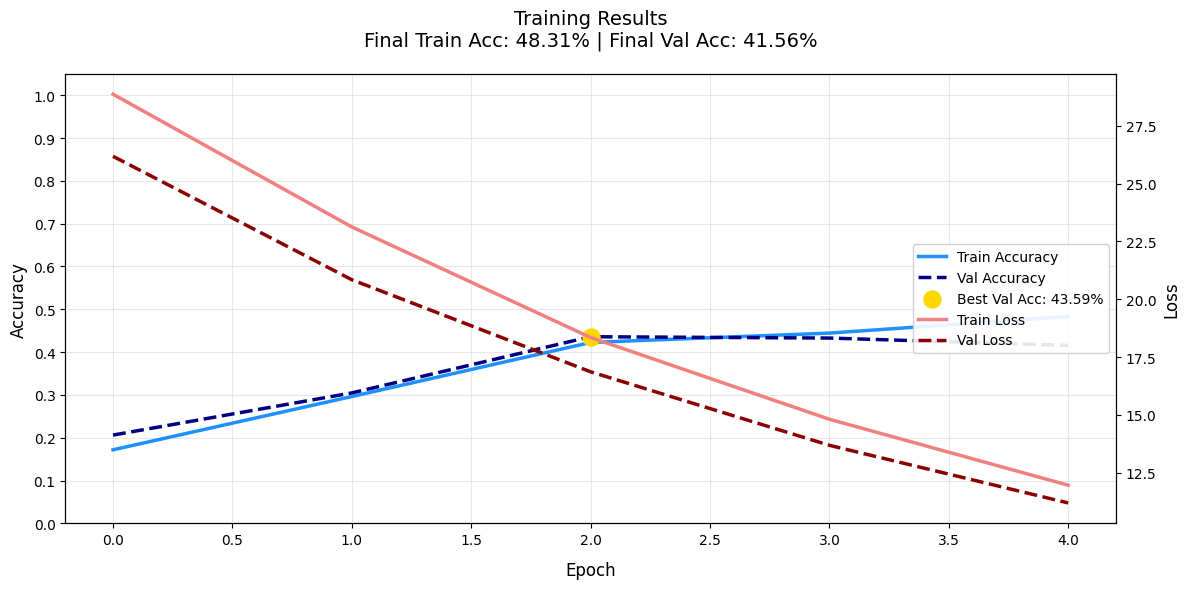

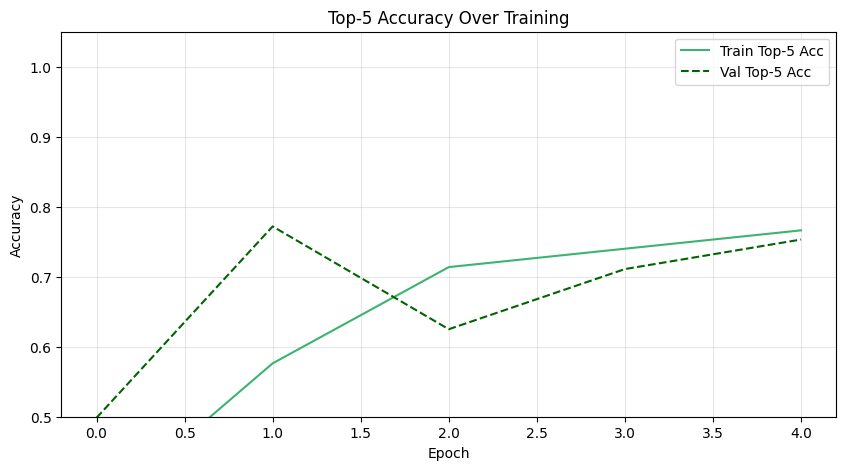

In [ ]:
def plot_training_history(history, figsize=(12, 6)):
    """
    Enhanced training history visualization with:
    - Dual-axis metrics
    - Custom styling
    - Annotations
    - Professional formatting
    """
    plt.figure(figsize=figsize)

    # Create subplots
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Plot accuracy metrics
    ax1.plot(history.history['accuracy'],
             color='dodgerblue',
             linewidth=2.5,
             label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'],
             color='navy',
             linestyle='--',
             linewidth=2.5,
             label='Val Accuracy')

    # Plot loss metrics
    ax2.plot(history.history['loss'],
             color='lightcoral',
             linewidth=2.5,
             label='Train Loss')
    ax2.plot(history.history['val_loss'],
             color='darkred',
             linestyle='--',
             linewidth=2.5,
             label='Val Loss')

    # Find and mark best validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_acc = history.history['val_accuracy'][best_epoch]
    ax1.scatter(best_epoch, best_acc,
                color='gold',
                s=150,
                zorder=5,
                label=f'Best Val Acc: {best_acc:.2%}')

    # Styling
    ax1.set_xlabel('Epoch', fontsize=12, labelpad=10)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax1.set_ylim([0, 1.05])
    ax1.set_yticks(np.linspace(0, 1, 11))
    ax1.grid(alpha=0.3)
    ax2.grid(False)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
               loc='center right',
               framealpha=0.9)

    # Title with key metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    plt.title(f'Training Results\nFinal Train Acc: {final_train_acc:.2%} | Final Val Acc: {final_val_acc:.2%}',
              pad=20,
              fontsize=14)

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history(training_history)

# Additional visualization for top-5 accuracy if available
if 'val_top_5_accuracy' in training_history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(training_history.history['top_5_accuracy'],
             label='Train Top-5 Acc',
             color='mediumseagreen')
    plt.plot(training_history.history['val_top_5_accuracy'],
             label='Val Top-5 Acc',
             color='darkgreen',
             linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1.05])
    plt.legend()
    plt.title('Top-5 Accuracy Over Training')
    plt.grid(alpha=0.3)
    plt.show()


🍎 Food Nutrition Analyzer 🍔
Loading food classification model...

Choose an option:
1. Upload an image
2. Use sample image
Enter choice (1 or 2): 1

Please upload an image file:


Saving 360_F_274990113_ffVRBygLkLCZAATF9lWymzE6bItMVuH1.jpg to 360_F_274990113_ffVRBygLkLCZAATF9lWymzE6bItMVuH1.jpg
✅ Image loaded from file


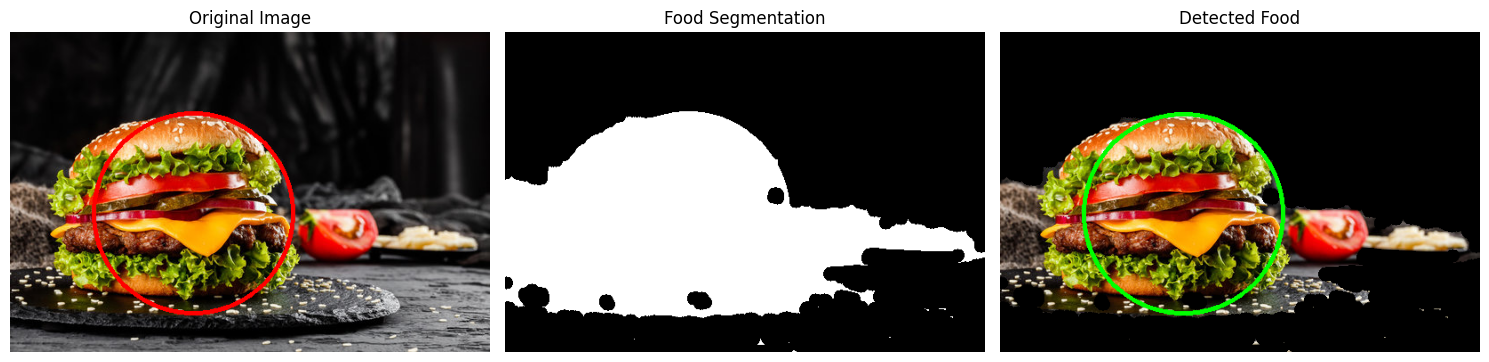


📊 Analysis Results:
Food Type: Default
Estimated Portion: 2000.0 ml
Estimated Calories: 3500.0 kcal

🍽️ Nutrition Facts (approximate):
• Food category: default
• Serving size: 2000 ml
• Calories: 3500 kcal
• Note: Estimates may vary based on actual ingredients


In [ ]:
"""
Food Recognition and Calorie Estimation System
Enhanced Google Colab Implementation with:
- Better portion estimation
- Food classification
- Calorie calculation
- Improved visualization
"""

import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from google.colab import files
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

class FoodNutritionAnalyzer:
    def __init__(self):
        # Initialize food database (simplified example)
        self.food_db = {
            'pizza': {'calories': 285, 'density': 0.6},  # per 100g
            'salad': {'calories': 35, 'density': 0.3},
            'burger': {'calories': 295, 'density': 0.8},
            'pasta': {'calories': 131, 'density': 0.5},
            'default': {'calories': 250, 'density': 0.7}
        }

        # Load food classification model (placeholder - would use actual model in production)
        self.classifier = self._load_classifier_model()

    def _load_classifier_model(self):
        """Load food classification model (placeholder implementation)"""
        print("Loading food classification model...")
        # In a real implementation, this would load a trained model
        return None

    def classify_food(self, img):
        """Classify food type from image (simplified example)"""
        # This is a placeholder - real implementation would use ML model
        img_array = np.array(img)

        # Simple color-based classification (for demo purposes)
        avg_color = np.mean(img_array, axis=(0, 1))

        if avg_color[1] > avg_color[0] + 20:  # Green dominant
            return 'salad'
        elif avg_color[0] > 150:  # Red dominant
            return 'pizza'
        else:
            return 'default'

    def load_image(self, image_path):
        """Enhanced image loading with better error handling"""
        try:
            if image_path.startswith('http'):
                response = requests.get(image_path, timeout=10)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content))
                print("✅ Image loaded from URL")
            else:
                img = Image.open(image_path)
                print("✅ Image loaded from file")

            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')

            return img

        except requests.exceptions.RequestException as e:
            print(f"❌ URL Error: {str(e)}")
        except IOError as e:
            print(f"❌ File Error: {str(e)}")
        except Exception as e:
            print(f"❌ Unexpected Error: {str(e)}")

        return None

    def estimate_portion(self, img):
        """Enhanced portion estimation with reference object detection"""
        try:
            # Convert to OpenCV format
            img_array = np.array(img)
            img_cv = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

            # Plate detection (simplified - would use ML in production)
            gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, (11, 11), 0)
            circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, 100,
                                     param1=100, param2=30, minRadius=50, maxRadius=300)

            if circles is not None:
                # Use detected plate
                circles = np.round(circles[0, :]).astype("int")
                (x, y, r) = circles[0]
                plate_diameter_pixels = 2 * r
                cv2.circle(img_cv, (x, y), r, (0, 255, 0), 4)
            else:
                # Fallback to image dimensions
                height, width = img_cv.shape[:2]
                plate_diameter_pixels = min(height, width) * 0.7

            # Calculate pixels per cm (assuming standard 25cm plate)
            pixels_per_cm = plate_diameter_pixels / 25.0

            # Food segmentation (simplified)
            hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)

            # Define broader color ranges for food detection
            lower_food = np.array([0, 40, 40])
            upper_food = np.array([179, 255, 255])
            mask = cv2.inRange(hsv, lower_food, upper_food)

            # Clean up mask
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

            # Calculate food area
            food_area_pixels = cv2.countNonZero(mask)
            food_area_cm2 = food_area_pixels / (pixels_per_cm ** 2)

            # Estimate volume (with height assumption)
            avg_height_cm = 3.0  # Average food height in cm
            volume_ml = food_area_cm2 * avg_height_cm * 10  # Convert to ml

            # Constrain to reasonable values
            volume_ml = max(50, min(volume_ml, 2000))

            # Visualization
            self._visualize_results(img_cv, mask, circles)

            return volume_ml

        except Exception as e:
            print(f"⚠️ Portion estimation error: {str(e)}")
            return 300  # Default reasonable value

    def _visualize_results(self, img, mask, circles=None):
        """Enhanced visualization of analysis results"""
        plt.figure(figsize=(15, 5))

        # Original image with plate detection
        plt.subplot(1, 3, 1)
        display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if circles is not None:
            (x, y, r) = circles[0]
            cv2.circle(display_img, (x, y), r, (255, 0, 0), 3)
        plt.imshow(display_img)
        plt.title("Original Image")
        plt.axis('off')

        # Food segmentation mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Food Segmentation")
        plt.axis('off')

        # Highlighted food areas
        plt.subplot(1, 3, 3)
        masked_img = cv2.bitwise_and(img, img, mask=mask)
        plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
        plt.title("Detected Food")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def estimate_calories(self, food_type, volume_ml):
        """Calculate estimated calories based on food type and volume"""
        try:
            food_data = self.food_db.get(food_type, self.food_db['default'])

            # Convert volume to mass using density (g/cm^3)
            mass_g = volume_ml * food_data['density']

            # Calculate calories
            calories = (mass_g / 100) * food_data['calories']

            return calories

        except Exception as e:
            print(f"⚠️ Calorie estimation error: {str(e)}")
            return 300  # Default reasonable value

    def analyze_food(self, image_path):
        """Complete food analysis pipeline"""
        img = self.load_image(image_path)
        if img is None:
            print("❌ Could not process image")
            return None, None, None

        # Analyze image
        food_type = self.classify_food(img)
        volume_ml = self.estimate_portion(img)
        calories = self.estimate_calories(food_type, volume_ml)

        return food_type, volume_ml, calories

def main():
    print("\n🍎 Food Nutrition Analyzer 🍔")
    print("============================")

    analyzer = FoodNutritionAnalyzer()

    # Get user input
    print("\nChoose an option:")
    print("1. Upload an image")
    print("2. Use sample image")
    choice = input("Enter choice (1 or 2): ")

    if choice == '1':
        # Upload image
        print("\nPlease upload an image file:")
        uploaded = files.upload()
        if not uploaded:
            print("⚠️ No file uploaded. Using sample image instead.")
            image_path = "https://images.unsplash.com/photo-1546069901-ba9599a7e63c"
        else:
            image_path = next(iter(uploaded.keys()))
    else:
        # Use sample image
        image_path = "https://images.unsplash.com/photo-1546069901-ba9599a7e63c"

    # Analyze food
    food_type, volume_ml, calories = analyzer.analyze_food(image_path)

    # Display results
    if food_type is not None:
        print("\n📊 Analysis Results:")
        print(f"Food Type: {food_type.capitalize()}")
        print(f"Estimated Portion: {volume_ml:.1f} ml")
        print(f"Estimated Calories: {calories:.1f} kcal")

        # Display nutrition facts
        print("\n🍽️ Nutrition Facts (approximate):")
        print(f"• Food category: {food_type}")
        print(f"• Serving size: {volume_ml:.0f} ml")
        print(f"• Calories: {calories:.0f} kcal")
        print("• Note: Estimates may vary based on actual ingredients")

if __name__ == "__main__":
    main()